### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [12]:
import os
os.chdir("/vol/week5")

In [38]:
import os
start_token = " "

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [39]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)
    


n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


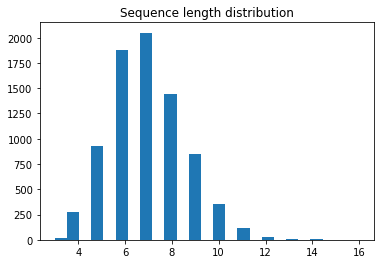

In [40]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [46]:
#all unique characters go here
tokens = set(''.join(set(names)))

tokens = list(tokens)
tokens.append("#")

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60


n_tokens =  56


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign 

In [47]:
token_to_id =  {c: i for i, c in enumerate(tokens)} ###YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens }



In [48]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [49]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [50]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]).T)

 Abagael
 Glory
 Prissie
 Giovanne
[[26 26 26 26]
 [42 50 32 50]
 [47 29  5 48]
 [ 2  6 48  6]
 [12  5 11  1]
 [ 2 40 11  2]
 [28 55 48  8]
 [29 55 28  8]
 [55 55 55 28]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [51]:
import keras
from keras.layers import Concatenate,Dense,Embedding
from keras.layers.advanced_activations import LeakyReLU

rnn_num_units = 64
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings


#a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation='relu')

#a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax')

#Note: please either set the correct activation to Dense or write it manually in rnn_one_step

In [52]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    
    Follow inline isntructions to complete the function.
    """
    #convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    
    #concatenate x embedding and previous h state
    x_and_h = Concatenate()([x_t_emb, h_t])
    
    #compute next state given x_and_h
    h_next = get_h_next(x_and_h) 
    
    #get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas,h_next

### RNN loop

Once rnn_one_step is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [53]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) #initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

## RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.

Our network can then be trained by minimizing crossentropy between predicted probabilities and those answers.

In [54]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [55]:
loss = keras.losses.categorical_crossentropy(predictions_matrix, answers_matrix)

optimize = tf.train.AdamOptimizer().minimize(loss)

### The training loop

In [56]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

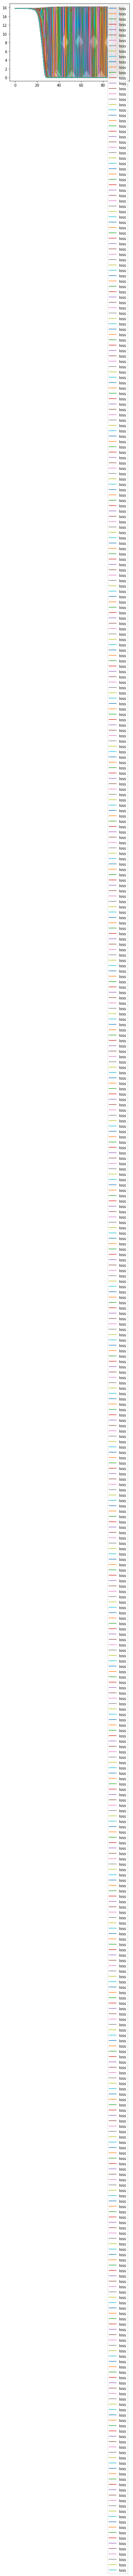

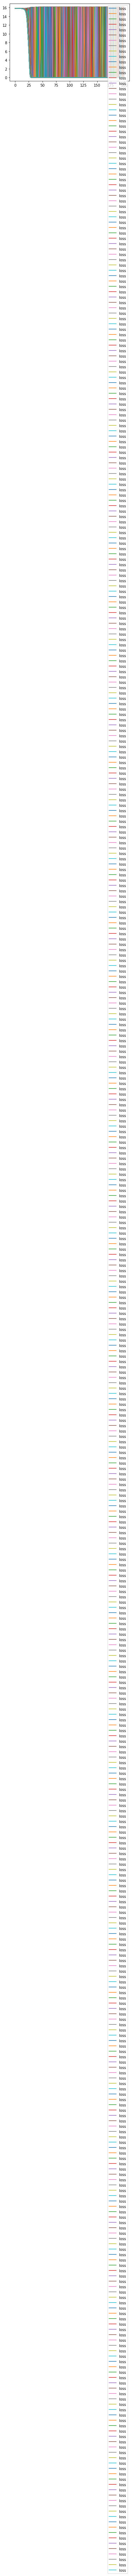

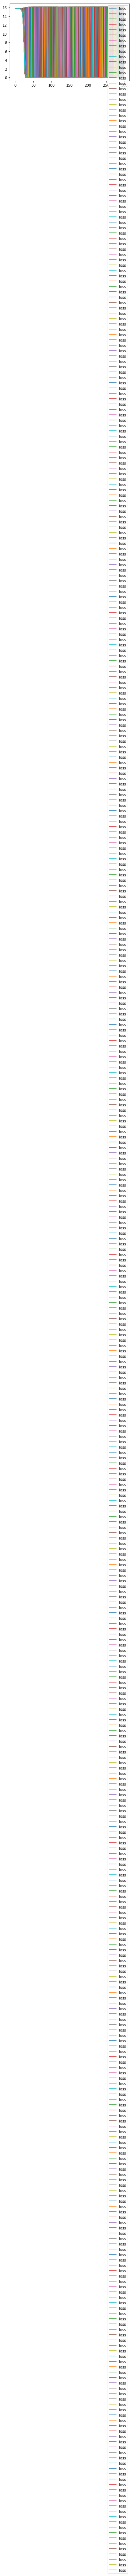

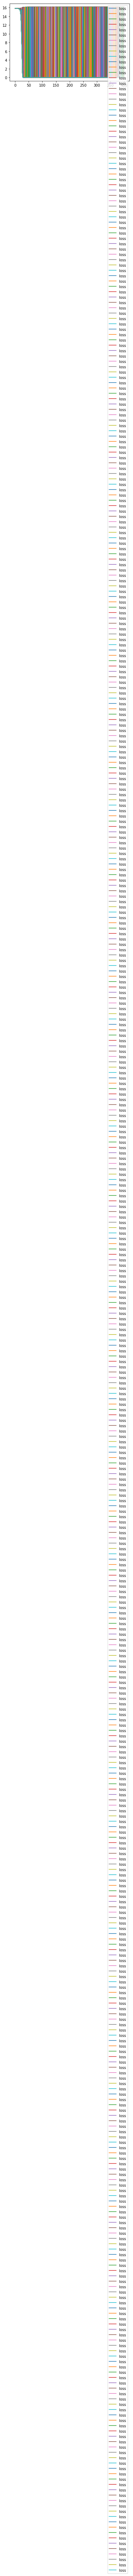

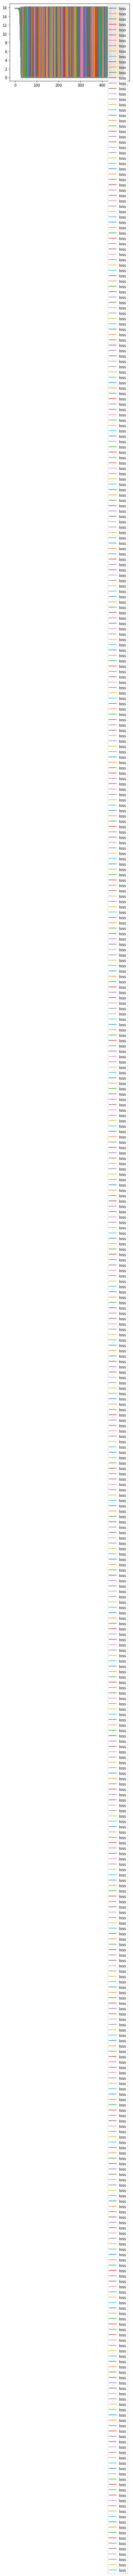

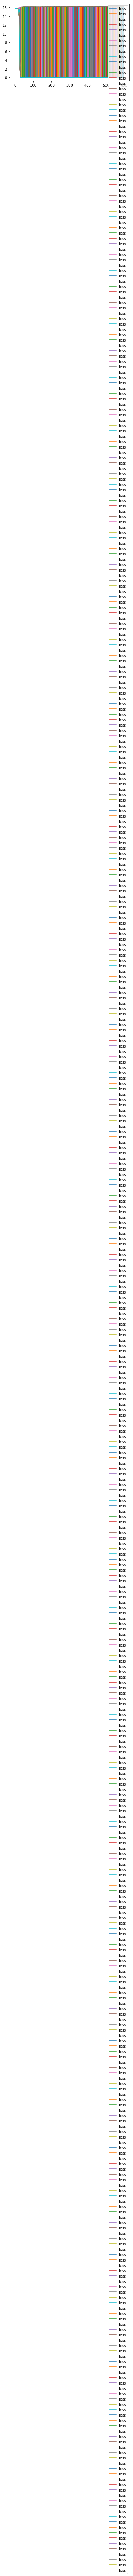

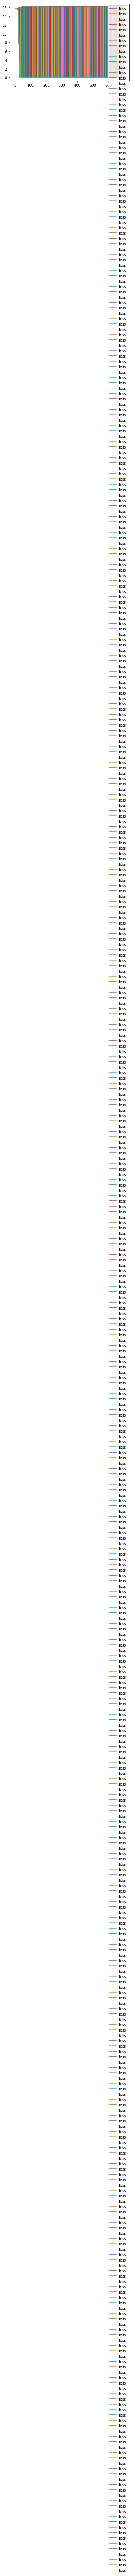

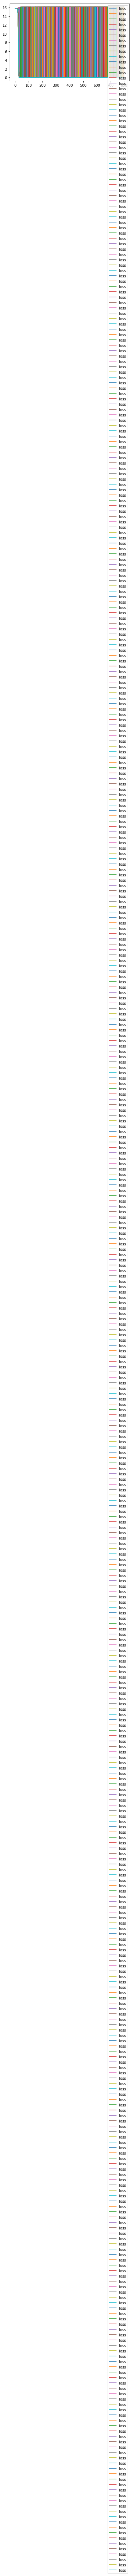

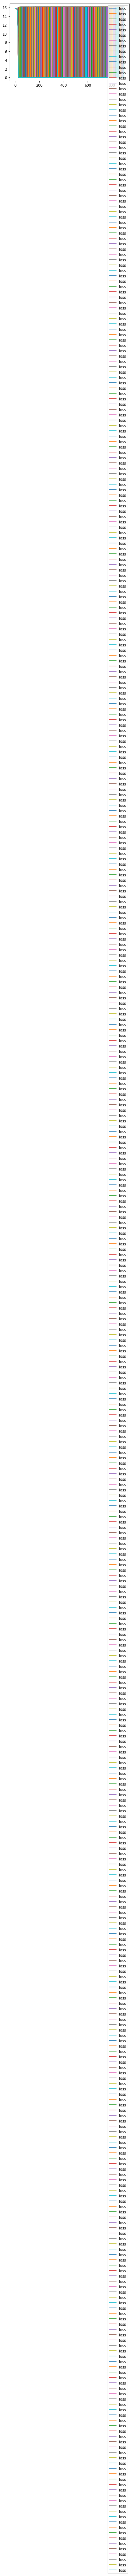

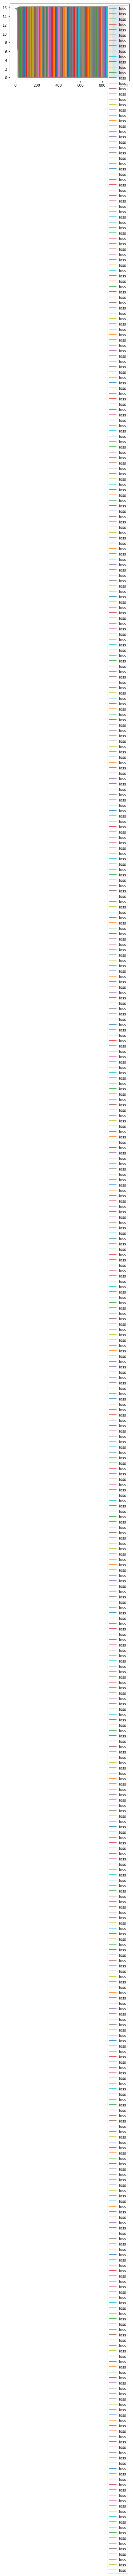

In [28]:

for i in range(1000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [29]:
x_t = tf.placeholder('int32',(1,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

next_probs,next_h = rnn_one_step(x_t,h_t)

In [30]:
def generate_sample(seed_phrase=' ',max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [31]:
for _ in range(10):
    print(generate_sample())

 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


 Marrwwwwwwwwwww


In [32]:
for _ in range(50):
    print(generate_sample(' Trump'))

 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


 Trumpwwwwwwwwww


### Submit to coursera

In [33]:
from submit import submit_char_rnn
samples = [generate_sample(' Al') for i in range(25)]
submission = (history,samples)
submit_char_rnn(submission, "ssanya.markelov@gmail.com", "0WV01yqN8hUFGa8e")

Submitted to Coursera platform. See results on assignment page!


### Try it out!

__Disclaimer:__ This assignment is entirely optional. You won't receive bonus points for it. However, it's a fun thing to do. Please share your results on course forums.

You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

### Bonus level: dynamic RNNs

Apart from keras, there's also a friendly tensorflow API for recurrent neural nets. It's based around the symbolic loop function (aka [scan](https://www.tensorflow.org/api_docs/python/tf/scan)).

This interface allows for dynamic sequence length and comes with some pre-implemented architectures.

In [ ]:
class CustomRNN(tf.nn.rnn_cell.BasicRNNCell):
    def call(self,input,state):
        return rnn_one_step(input[:,0],state)
    
    @property
    def output_size(self):
        return n_tokens

cell = CustomRNN(rnn_num_units)

input_sequence = tf.placeholder('int32',(None,None))
    
predicted_probas, last_state = tf.nn.dynamic_rnn(cell,input_sequence[:,:,None],
                                                 time_major=True,dtype='float32')

print(predicted_probas.eval({input_sequence:to_matrix(names[:10],max_len=50)}).shape)

Note that we never used MAX_LENGTH in the code above: TF will iterate over however many time-steps you gave it.

You can also use the all the pre-implemented RNN cells:

In [ ]:
for obj in dir(tf.nn.rnn_cell)+dir(tf.contrib.rnn):
    if obj.endswith('Cell'):
        print (obj)

In [ ]:
input_sequence = tf.placeholder('int32',(None,None))

inputs_embedded = embed_x(input_sequence)

cell = tf.nn.rnn_cell.LSTMCell(rnn_num_units)

state_sequence,last_state = tf.nn.dynamic_rnn(cell,inputs_embedded,dtype='float32')

print('LSTM visible states[time,batch,unit]:', state_sequence)